In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
from huggingface_hub import login
login()

In [3]:
from datasets import load_dataset

def load_dataset_first_100_rows(dataset_name: str, split: str = "train"):
    dataset = load_dataset(dataset_name, split=split)
    return dataset.select(range(100))


def select_columns(dataset, columns: list):
    return dataset.remove_columns([col for col in dataset.column_names if col not in columns])


In [4]:

dataset_name = "nehulagrawal/products_images"  # Replace with any dataset from Hugging Face
columns_to_select = ["image", "answers"]  # Replace with the columns you want to select


first_100_rows = load_dataset_first_100_rows(dataset_name)


image_text_pairs = select_columns(first_100_rows, columns_to_select)


README.md:   0%|          | 0.00/691 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/9.67M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.39M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20399 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/537 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/537 [00:00<?, ? examples/s]

In [5]:
image_text_pairs

Dataset({
    features: ['image', 'answers'],
    num_rows: 100
})

In [6]:
def extract_text_from_list(entry):
    if isinstance(entry['answers'], list) and len(entry['answers']) > 0:
        return entry['answers'][0]
    return entry['answers']  
    
image_text_pairs = image_text_pairs.map(lambda row: {'answers': extract_text_from_list(row)})

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [7]:
def print_dataset_rows(dataset, num_rows: int = 5):
    if num_rows > len(dataset):
        print(f"The dataset only contains {len(dataset)} rows. Printing all rows.")
        num_rows = len(dataset)
    
    for i in range(num_rows):
        print(f"Row {i + 1}:")
        print(dataset[i])
        print("-" * 50)
        
print_dataset_rows(image_text_pairs, 3)

Row 1:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=210x320 at 0x7F34C6D3ACB0>, 'answers': 'Maxim Mocha Gold Mild Coffee Carton Mix(100 Sticks),1200 Grams'}
--------------------------------------------------
Row 2:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x247 at 0x7F34B492CB20>, 'answers': 'MONSOON HARVEST Wingreens Crunchy Millet Granola Bars - Cranberry & Orange - Pack of 6, Healthy Vegan Breakfast Energy Bars, Gluten Free, High Fiber, (40 Grams Each), with Rolled Oats'}
--------------------------------------------------
Row 3:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=307x320 at 0x7F34B48B8D90>, 'answers': 'Valley Spice Popular Coriander Powder Dhania Powder Pure & Authentic (500g || Pack of 2)'}
--------------------------------------------------


In [8]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np

def initialize_clip_model(model_name: str = "openai/clip-vit-base-patch32") -> tuple:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CLIPModel.from_pretrained(model_name).to(device)
    processor = CLIPProcessor.from_pretrained(model_name)
    return model, processor, device


def generate_text_embeddings(model: CLIPModel, processor: CLIPProcessor, texts: list, device: str, batch_size: int = 16) -> np.ndarray:
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = processor(text=batch_texts, return_tensors="pt", padding=True).to(device)
            outputs = model.get_text_features(**inputs)
            outputs = outputs / outputs.norm(p=2, dim=1, keepdim=True)
            embeddings.append(outputs.cpu().numpy())
    return np.vstack(embeddings)


def generate_image_embeddings(model: CLIPModel, processor: CLIPProcessor, image_paths: list, device: str, batch_size: int = 16) -> np.ndarray:
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(image_paths), batch_size):
            batch_images = image_paths[i:i + batch_size]
            # If image_paths are file paths, open them
            processed_images = []
            for img in batch_images:
                if isinstance(img, str):
                    processed_images.append(Image.open(img).convert("RGB"))
                elif isinstance(img, Image.Image):
                    processed_images.append(img.convert("RGB"))
                else:
                    raise ValueError("Images should be file paths or PIL Image instances.")
            inputs = processor(images=processed_images, return_tensors="pt").to(device)
            outputs = model.get_image_features(**inputs)
            outputs = outputs / outputs.norm(p=2, dim=1, keepdim=True)
            embeddings.append(outputs.cpu().numpy())
    return np.vstack(embeddings)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:

model, processor, device = initialize_clip_model()

texts = image_text_pairs["answers"]
images = image_text_pairs["image"] 

text_embeddings = generate_text_embeddings(model, processor, texts, device)


image_embeddings = generate_image_embeddings(model, processor, images, device)


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
import faiss

def create_faiss_index(embeddings: np.ndarray, index_type: str = "Flat") -> faiss.Index:
    dimension = embeddings.shape[1]
    if index_type == "Flat":
        index = faiss.IndexFlatL2(dimension)
    elif index_type == "IVF":
        nlist = 100  # Number of clusters
        quantizer = faiss.IndexFlatL2(dimension)
        index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)
        index.train(embeddings)
    else:
        raise ValueError(f"Unsupported index type: {index_type}")
    
    index.add(embeddings)
    return index


def save_faiss_index(index: faiss.Index, file_path: str):

    faiss.write_index(index, file_path)


def load_faiss_index(file_path: str) -> faiss.Index:
    return faiss.read_index(file_path)


In [11]:
text_faiss_index = create_faiss_index(text_embeddings, index_type="Flat")

save_faiss_index(text_faiss_index, "text_faiss.index")

image_faiss_index = create_faiss_index(image_embeddings, index_type="Flat")

save_faiss_index(image_faiss_index, "image_faiss.index")


In [12]:
import numpy as np
import faiss
from PIL import Image

def retrieve_image_and_text(query_image, image_faiss_index, image_embeddings, dataset, processor, model, device, top_k=1):
    
    if isinstance(query_image, str):
        query_image = Image.open(query_image).convert("RGB")
    query_image = processor(images=query_image, return_tensors="pt").to(device)

    model.eval()
    with torch.no_grad():
        query_image_embedding = model.get_image_features(**query_image)
        query_image_embedding = query_image_embedding / query_image_embedding.norm(p=2, dim=1, keepdim=True)
        query_image_embedding = query_image_embedding.cpu().numpy()

    _, indices = image_faiss_index.search(query_image_embedding, top_k)

    results = []
    for idx in indices[0]:
        idx = int(idx)
        matched_image = dataset[idx]["image"]  
        matched_text = dataset[idx]["answers"] 
        results.append((matched_image, matched_text))
    
    return results


Retrieved Text: Oreo Cadbury Chocolatey Flavour Crème Sandwich Biscuit, 288.75 Gram (Packaging May Vary)


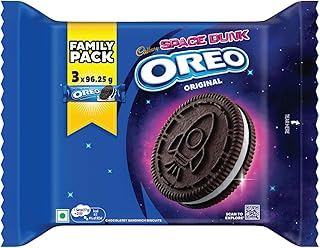

In [13]:
model, processor, device = initialize_clip_model()


query_image_path = "oreo_pic.jpg" 

retrieved_results = retrieve_image_and_text(
    query_image=query_image_path,
    image_faiss_index=image_faiss_index,
    image_embeddings=image_embeddings,
    dataset=image_text_pairs,
    processor=processor,
    model=model,
    device=device,
    top_k=1
)


for image, text in retrieved_results:
    print(f"Retrieved Text: {text}")
    image.show()  


In [14]:
retrieved_results

[(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x248>,
  'Oreo Cadbury Chocolatey Flavour Crème Sandwich Biscuit, 288.75 Gram (Packaging May Vary)')]

In [15]:
import requests
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)


config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [16]:
def process_inputs(messages, image, processor):
    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)
    
    return inputs
    

In [17]:
def generate_output(processed_contents):
    
    return model.generate(**processed_contents, max_new_tokens=256)


In [23]:
def main(query):
    processor = AutoProcessor.from_pretrained(model_id)

    # url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
    # image = Image.open(requests.get(url, stream=True).raw)
    image, text = retrieved_results[0]
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": f"""You are a helpful assistant for an online store. Use the given image and context {text} to answer
    user {query} and provide persuade the user to buy the product."""},
            
        ]}
    ]
    
    processed_contents = process_inputs(messages, image, processor)
    output = generate_output(processed_contents)
    print(processor.decode(output[0]))


In [24]:
query = "Is this cookie available?"
main(query)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>You are a helpful assistant for an online store. Use the given image and context Oreo Cadbury Chocolatey Flavour Crème Sandwich Biscuit, 288.75 Gram (Packaging May Vary) to answer
    user Is this cookie available? and provide persuade the user to buy the product.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I'm happy to help you with that!

The image you provided shows a pack of Oreo Cadbury Chocolatey Flavour Crème Sandwich Biscuit, which is a popular cookie brand. According to the image, the product is available in a family pack of 3, weighing 96.25 grams each, and comes in a packaging that may vary.

As for whether this cookie is available, I can tell you that Oreo cookies are widely available in most supermarkets and online stores. However, availability may vary depending on your location and the retailer you're shopping from.

If you're interested in purchasing this product, I would recommend checking 